How does Earths land surface relief affect climate? Or the other way round: What would be if there were no mountain ranges and depressions and the surface was completely flat?

This question was addressed with climate model simulations and analyses at the Earth System Modelling School (EaSyMS) at the Max-Planck-Institute for Meteorology in September 2022. Simulations for this scenario were performed with the [ICON-ESM](https://mpimet.mpg.de/en/science/models/icon-esm) and compared with an undisturbed control run. Minimal parameter changes yielded an ensemble of three model realizations which were averaged to account for internal variability. The model ran for 500 years, respectively, of which the last 50 years were averaged and used for analysis. The lowest resolution configuration of the ICON-ESM ([Ruby SWITCH](https://mpimet.mpg.de/en/science/modeling-with-icon/icon-configurations/icon-ruby-icon-esm)) was used, having grid cell sizes around 320 km (R2B3) in the atmosphere and 160 km (R2B4) in the ocean.

This Notebook was prepared by Jan Landwehrs, but resulted from the group work with Anna Luisa Hemshorn de Sánchez, Hairu Ding, Maria Jesus Rapanague Sepulveda, Quan Liu and Roberta D'Agostino (alphabetical order).

# Preparations

In [1]:
import xarray as xr
xr.set_options(keep_attrs=True)
import numpy as np
import xesmf as xe

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean

import os
import warnings
warnings.filterwarnings('ignore')


""" 
Load some helper functions for
    - regridding ICON data from unstructured triangular grid to equirectangular grid
    - interpolating atm data from height to pressure levels
    - computing meridional overturning stream function
Requires i.a. a local copy of pyICON (https://gitlab.dkrz.de/m300602/pyicon)
"""
%run ./functions.ipynb

cbar_dict={'pad':0.02}

## Load Data

In [2]:
"""
Loading processed model output files.
Averages over the last 50 years were calculated with CDO ymonmean and timmean.
CDO setgrid was used to incorporate horizontal grid information from the ICON grid files.
These van be retrieved from the URLs given in the output data (see below). 
Additionally, the NetCDF were compressed for upload. (ncks -O -7 -L 1 --baa=4 --ppc default=3 --no_alphabetize)
"""

ds_atm_2d=xr.open_dataset('./data_sel/sus22F0_atm_2d_ml_last50yrs_setgrid_sel.nc')
ds_atm_2d_ctrl=xr.open_dataset('./data_sel/sus2200_atm_2d_ml_last50yrs_setgrid_sel.nc')

ds_atm_3d=xr.open_dataset('./data_sel/sus22F0_atm_3d_ml_last50yrs_setgrid_sel.nc')
ds_atm_3d_ctrl=xr.open_dataset('./data_sel/sus2200_atm_3d_ml_last50yrs_setgrid_sel.nc')

ds_atm_mon=xr.open_dataset('./data_sel/sus22F0_atm_mon_last50yrs_sel.nc')
ds_atm_mon_ctrl=xr.open_dataset('./data_sel/sus2200_atm_mon_last50yrs_sel.nc')

ds_lnd=xr.open_dataset('./data_sel/sus22F0_lnd_basic_ml_last50yrs_setgrid_sel.nc')
ds_lnd_ctrl=xr.open_dataset('./data_sel/sus2200_lnd_basic_ml_last50yrs_setgrid_sel.nc')

ds_oce=xr.open_dataset('./data_sel/sus22F0_oce_P1M_2d_last50yrs_setgrid_sel.nc')
ds_oce_ctrl=xr.open_dataset('./data_sel/sus2200_oce_P1M_2d_last50yrs_setgrid_sel.nc')

ds_oce_3D_ctrl=xr.open_dataset('./data_sel/sus2200_oce_P1M_3d_last50yrs_setgrid_sel.nc')

ds_oce_moc=xr.open_dataset('./data_sel/sus22F0_oce_P1M_moc_last50yrs_sel.nc')
ds_oce_moc_ctrl=xr.open_dataset('./data_sel/sus2200_oce_P1M_moc_last50yrs_sel.nc')

ds_hamocc_monitor=xr.open_dataset('./data_sel/sus22F0_hamocc_monitor_last50yrs_sel.nc')
ds_hamocc_monitor_ctrl=xr.open_dataset('./data_sel/sus2200_hamocc_monitor_last50yrs_sel.nc')

if os.path.isfile('./data_sel/icon_grid_0030_R02B03_G.nc')==False:
    url = 'http://icon-downloads.mpimet.mpg.de/grids/public/mpim/0030/icon_grid_0030_R02B03_G.nc'
    os.system('wget -q -O ./data_sel/icon_grid_0030_R02B03_G.nc {};'.format(url))
    url = 'http://icon-downloads.mpimet.mpg.de/grids/public/mpim/0036/icon_grid_0036_R02B04_O.nc'
    os.system('wget -q -O ./data_sel/icon_grid_0036_R02B04_O.nc {};'.format(url))

grid_atm=xr.open_dataset('./data_sel/icon_grid_0030_R02B03_G.nc')
grid_ocn=xr.open_dataset('./data_sel/icon_grid_0036_R02B04_O.nc')


## Regrid Data

In [3]:
ds_atm_2d_regrid=regrid_rec(ds_atm_2d)
ds_atm_2d_ctrl_regrid=regrid_rec(ds_atm_2d_ctrl)

ds_atm_3d_ctrl_regrid=regrid_rec(ds_atm_3d_ctrl)

ds_oce_regrid=regrid_rec(ds_oce)
ds_oce_ctrl_regrid=regrid_rec(ds_oce_ctrl)

ds_oce_3D_ctrl_regrid=regrid_rec(ds_oce_3D_ctrl)

ds_lnd_regrid=regrid_rec(ds_lnd)
ds_lnd_ctrl_regrid=regrid_rec(ds_lnd_ctrl)

# Forcing Scenario: Flat Earth

In the experiments the land surface elevation is set to zero everywhere. However, other land surface characteristics such as the runoff routing network, roughness and prescribe ice sheet albedo are not changed.

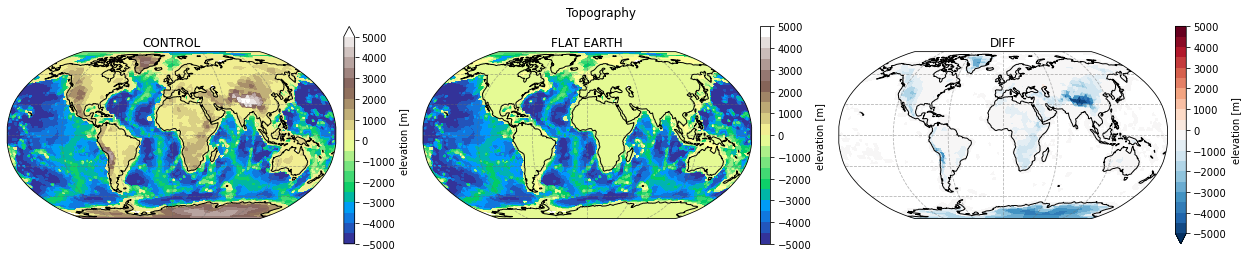

In [85]:
""" Plot Topography in the control run, flat Earth experiments and their difference """

varname='orog'
var=ds_atm_2d_regrid.data_vars[varname]
var_ctrl=ds_atm_2d_ctrl_regrid.data_vars[varname]
var_diff=(var-var_ctrl)

### determine bathymetry from ocean output
var_ocn=ds_oce_3D_ctrl_regrid.rho.isel(time=0) 
depths=(((var_ocn>0)*1)*ds_oce_3D_ctrl_regrid.depth).where(var_ocn>0)
depths_seafloor=-1*depths.max(dim='depth')

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4])

vmin,vmax,vdel,vN,levels,cmap_ctrl=colormap_settings(vmin=-5000,vmax=5000,vdel=500,var=var_ctrl,cmap_in=plt.cm.terrain,center=0)

depths_seafloor.plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap_ctrl,add_colorbar=False)
var_ctrl.where(var_ctrl>5).plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap_ctrl,cbar_kwargs=cbar_dict)
depths_seafloor.plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap='terrain',add_colorbar=False)
var.where(var_ctrl>5).plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap='terrain',cbar_kwargs=cbar_dict)
var_diff.where(var_diff!=0).plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels,cmap='RdBu_r',cbar_kwargs=cbar_dict) 

for ii in range(3,5+1):
    fig.get_axes()[ii].axes.set_yticks(levels[::2])
    fig.get_axes()[ii].axes.set_ylabel('elevation [m]')

plot_adjust(fig,axs,suptitle='Topography')

fig.savefig('./FlatEarth_topography.jpg',dpi=300, bbox_inches='tight', pad_inches=0.1)

Surface elevation is significantly decreased for the major mountain ranges but also the continental ice sheets in Antarctica and Greenland.

# Climatic Effects

## Surface Temperature

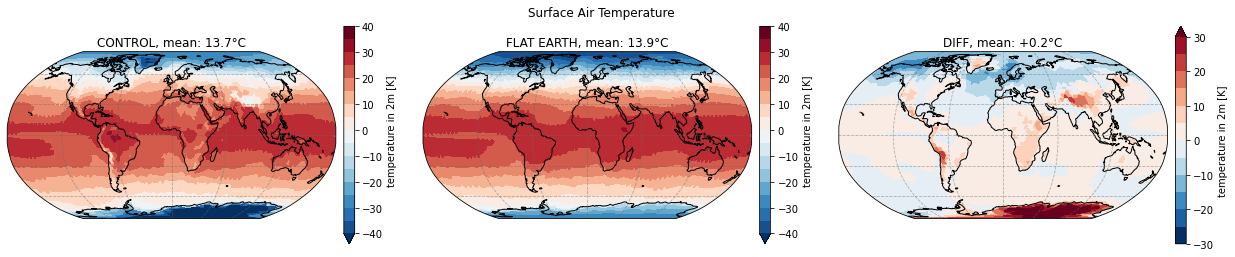

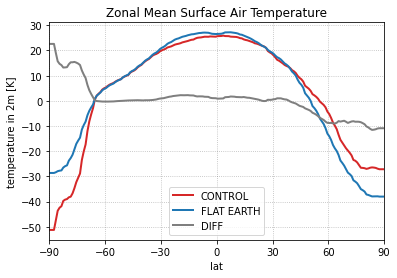

In [26]:
varname='tas'
var=ds_atm_2d_regrid.data_vars[varname].mean('time').isel(height_2=0)-273.15
var_ctrl=ds_atm_2d_ctrl_regrid.data_vars[varname].mean('time').isel(height_2=0)-273.15
var_diff=(var-var_ctrl)

### define color limits and levels; if colorbar values exceed the limits, colorbar is extended and shifted colormap is to recenter around zero
vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=-40,vmax=40,vdel=5,var=var,cmap_in=plt.cm.RdBu_r,center=0)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-30,vmax=30,vdel=5,var=var_diff,cmap_in=plt.cm.RdBu_r,center=0)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4])
var_ctrl.plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict) 
var.plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict)
var_diff.plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels_d,cmap=cmap_d,cbar_kwargs=cbar_dict)

weights = np.cos(np.deg2rad(var.lat))
var_mean = float(var.weighted(weights).mean(("lon", "lat")).values)
var_ctrl_mean = float(var_ctrl.weighted(weights).mean(("lon", "lat")).values)
var_diff_mean=float(var_diff.weighted(weights).mean(("lon", "lat")).values)

plot_adjust(fig,axs,suptitle='Surface Air Temperature',
            titles=['CONTROL, mean: {:.1f}°C'.format(var_ctrl_mean),'FLAT EARTH, mean: {:.1f}°C'.format(var_mean),
                    'DIFF, mean: {:+.1f}°C'.format(var_diff_mean)])

""" Plot Zonal Mean Temperature """

fig,axs=plt.subplots(1,1,figsize=[6,4],num=2)
var_ctrl.mean(dim='lon').plot(ax=axs,c='tab:red',label='CONTROL',lw=2) 
var.mean(dim='lon').plot(ax=axs,c='tab:blue',label='FLAT EARTH',lw=2) 
var_diff.mean(dim='lon').plot(ax=axs,c='tab:grey',label='DIFF',lw=2) 

axs.set_xlim([-90,90])
axs.set_xticks(range(-90,90+30,30))
axs.grid(c='dimgrey',ls=':', alpha=0.5)
axs.set_title('Zonal Mean Surface Air Temperature')
axs.legend();

The lowered elevation leads to strong local surface temperature changes which is most pronounced in East Antarctica. Meanwhile, there is a pronounced cooling of the northern high latitudes which is not a direct effect of the elevation changes. We will later see that this results from a more zonal circulation with less polewards heat transport, including a shutdown of the Atlantic Meridional Overturning Circulation (AMOC) and an amplification of the cooling in the north by expanding sea ice and snow with their high albedo. 

A slight warming of the zonal mean tropical surface temperatures together with the opposite temperature changes of the two polar regions, leads an increased equator-to-pole surface temperature contrast on the Northern hemisphere, while it is reduced in the southern hemisphere.

## Albedo, Clouds, Sea Ice, Snow

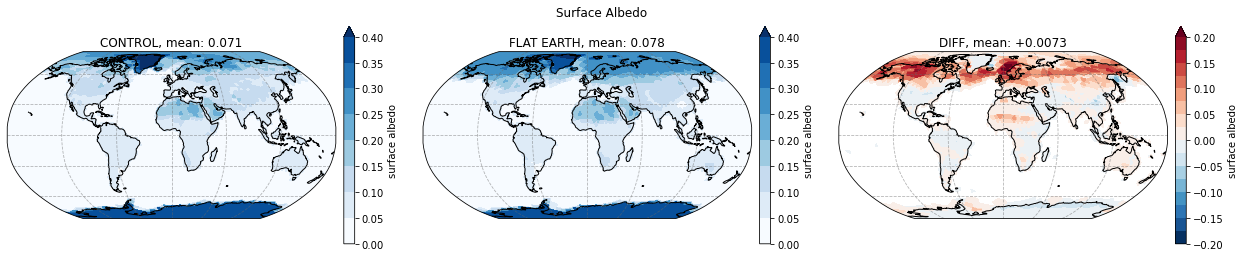

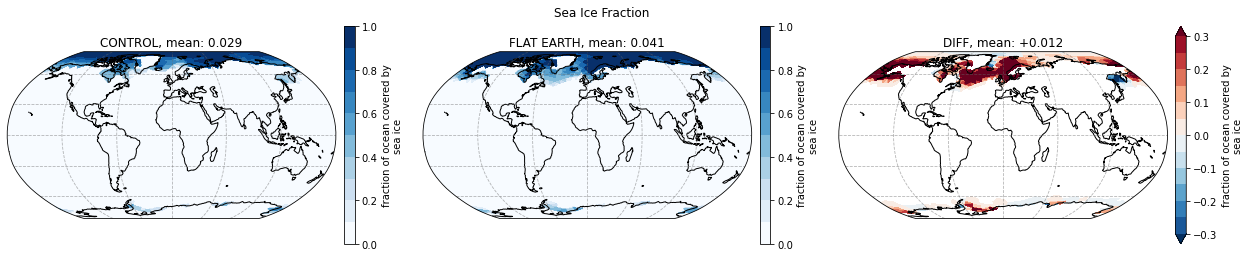

In [28]:
""" Plot Surface Albedo """

varname='albedo'
var=ds_atm_2d_regrid.data_vars[varname].mean('time')
var_ctrl=ds_atm_2d_ctrl_regrid.data_vars[varname].mean('time') 
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4])

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=0,vmax=0.4,vdel=0.05,var=var,cmap_in=plt.cm.Blues)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-0.2,vmax=0.2,vdel=0.025,var=var_diff,cmap_in=plt.cm.RdBu_r,center=0)

var_ctrl.plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict) 
var.plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict)
var_diff.where(var_diff!=0).plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels_d,cmap=cmap_d,cbar_kwargs=cbar_dict)

weights = np.cos(np.deg2rad(var.lat))
var_mean = float(var.weighted(weights).mean(("lon", "lat")).values)
var_ctrl_mean = float(var_ctrl.weighted(weights).mean(("lon", "lat")).values)
var_diff_mean=float(var_diff.weighted(weights).mean(("lon", "lat")).values)

plot_adjust(fig,axs,suptitle='Surface Albedo',
            titles=['CONTROL, mean: {:.2}'.format(var_ctrl_mean),'FLAT EARTH, mean: {:.2}'.format(var_mean),
                    'DIFF, mean: {:+.2}'.format(var_diff_mean)])


""" Plot Sea Ice Fraction """

varname='sic'
var=ds_atm_2d_regrid.data_vars[varname].mean('time')
var_ctrl=ds_atm_2d_ctrl_regrid.data_vars[varname].mean('time') 
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4])

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=0,vmax=1,vdel=0.1,var=var,cmap_in=plt.cm.Blues)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-0.3,vmax=0.3,vdel=0.05,var=var_diff,cmap_in=plt.cm.RdBu_r,center=0)

var_ctrl.plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict) 
var.plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict)
var_diff.where(var_diff!=0).plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels_d,cmap=cmap_d,cbar_kwargs=cbar_dict)

for aa in axs:
    aa.set_extent((-180.1,180.1,-90.1,90),crs=ccrs.PlateCarree())
    
weights = np.cos(np.deg2rad(var.lat))
var_mean = float(var.weighted(weights).mean(("lon", "lat")).values)
var_ctrl_mean = float(var_ctrl.weighted(weights).mean(("lon", "lat")).values)
var_diff_mean=float(var_diff.weighted(weights).mean(("lon", "lat")).values)

plot_adjust(fig,axs,suptitle='Sea Ice Fraction',
            titles=['CONTROL, mean: {:.2}'.format(var_ctrl_mean),'FLAT EARTH, mean: {:.2}'.format(var_mean),
                    'DIFF, mean: {:+.2}'.format(var_diff_mean)])

Given the large surface warming in Antarctica and Greenland, one would in reality expect a reduction of the ice and snow cover, resulting in a decreased surface albedo. We can see here that this is not happening in our experiments, because the ice sheet albedo is prescribed. Instead, the surface albedo changes are dominated by higher sea ice and snow coverage in the northern hemisphere. 

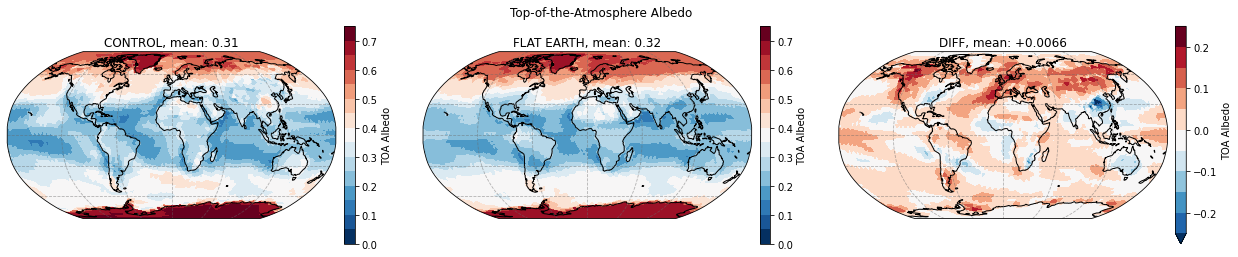

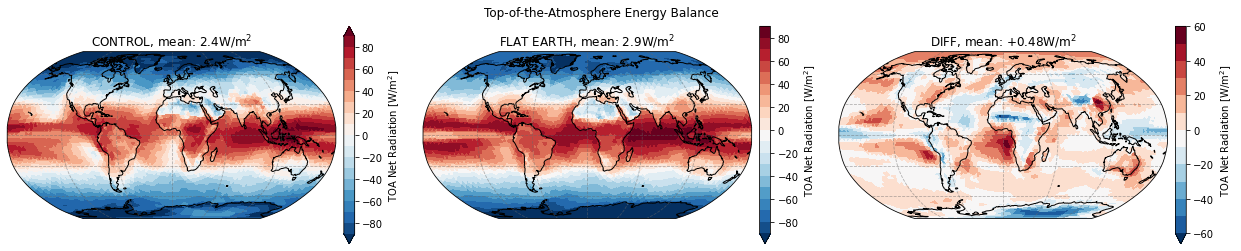

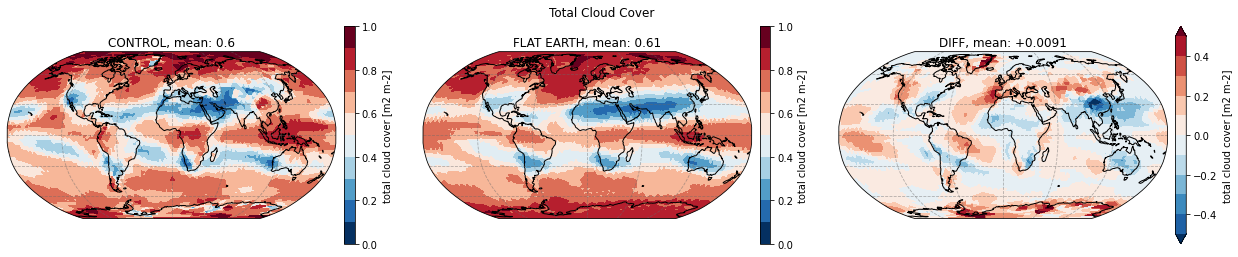

In [4]:
""" Plot Top-of-the-Atmosphere Albedo (ratio of incoming and outgoing shortwave radiation) """

var=(ds_atm_2d_regrid.data_vars['rsut']/ds_atm_2d_regrid.data_vars['rsdt']).mean('time')
var_ctrl=(ds_atm_2d_ctrl_regrid.data_vars['rsut']/ds_atm_2d_ctrl_regrid.data_vars['rsdt']).mean('time') 
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4],num=1)

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=0,vmax=0.75,vdel=0.05,var=var,cmap_in=plt.cm.RdBu_r)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-0.25,vmax=0.25,vN=10,var=var_diff,cmap_in=plt.cm.RdBu_r)

var_ctrl.plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs={'pad':0.02,'label':'TOA Albedo'}) 
var.plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs={'pad':0.02,'label':'TOA Albedo'})
var_diff.plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels_d,cmap=cmap_d,cbar_kwargs={'pad':0.02,'label':'TOA Albedo'}) 

weights = np.cos(np.deg2rad(var.lat))
var_mean = float(var.weighted(weights).mean(("lon", "lat")).values)
var_ctrl_mean = float(var_ctrl.weighted(weights).mean(("lon", "lat")).values)
var_diff_mean=float(var_diff.weighted(weights).mean(("lon", "lat")).values)

plot_adjust(fig,axs,suptitle='Top-of-the-Atmosphere Albedo',
            titles=['CONTROL, mean: {:.2}'.format(var_ctrl_mean),'FLAT EARTH, mean: {:.2}'.format(var_mean),
                    'DIFF, mean: {:+.2}'.format(var_diff_mean)])


""" Plot Top-of-the-Atmosphere Energy Balance (balance of incoming and outgoing short- and longwave radiation) """

ds_tmp=ds_atm_2d_regrid.copy()
var=(ds_tmp.rsdt-ds_tmp.rsut-ds_tmp.rlut).mean('time') 
ds_tmp=ds_atm_2d_ctrl_regrid.copy()
var_ctrl=(ds_tmp.rsdt-ds_tmp.rsut-ds_tmp.rlut).mean('time') 
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4],num=2)

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=-90,vmax=90,vdel=10,var=var,cmap_in=plt.cm.RdBu_r)
cmap_ctrl=colormap_settings(vmin=-90,vmax=90,vdel=10,var=var_ctrl,cmap_in=plt.cm.RdBu_r)[-1]
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-60,vmax=60,vdel=10,var=var_diff,cmap_in=plt.cm.RdBu_r)

var_ctrl.plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs={'pad':0.02,'label':'TOA Net Radiation [W/m$^2$]'}) 
var.plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap_ctrl,cbar_kwargs={'pad':0.02,'label':'TOA Net Radiation [W/m$^2$]'})
var_diff.plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels_d,cmap=cmap_d,cbar_kwargs={'pad':0.02,'label':'TOA Net Radiation [W/m$^2$]'})

weights = np.cos(np.deg2rad(var.lat))
var_mean = float(var.weighted(weights).mean(("lon", "lat")).values)
var_ctrl_mean = float(var_ctrl.weighted(weights).mean(("lon", "lat")).values)
var_diff_mean=float(var_diff.weighted(weights).mean(("lon", "lat")).values)

plot_adjust(fig,axs,suptitle='Top-of-the-Atmosphere Energy Balance',
            titles=['CONTROL, mean: {:.2}W/m$^2$'.format(var_ctrl_mean),'FLAT EARTH, mean: {:.2}W/m$^2$'.format(var_mean),
                    'DIFF, mean: {:+.2}W/m$^2$'.format(var_diff_mean)])


""" Plot Total Cloud Cover """

varname='clt'
var=ds_atm_2d_regrid.data_vars[varname].mean('time')
var_ctrl=ds_atm_2d_ctrl_regrid.data_vars[varname].mean('time') 
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4],num=3)

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=0,vmax=1,vdel=0.1,var=var,cmap_in=plt.cm.RdBu_r)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-0.5,vmax=0.5,vdel=0.1,var=var_diff,cmap_in=plt.cm.RdBu_r)

var_ctrl.plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict) 
var.plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict)
var_diff.plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels_d,cmap=cmap_d,cbar_kwargs=cbar_dict) 

weights = np.cos(np.deg2rad(var.lat))
var_mean = float(var.weighted(weights).mean(("lon", "lat")).values)
var_ctrl_mean = float(var_ctrl.weighted(weights).mean(("lon", "lat")).values)
var_diff_mean=float(var_diff.weighted(weights).mean(("lon", "lat")).values)

plot_adjust(fig,axs,suptitle='Total Cloud Cover',
            titles=['CONTROL, mean: {:.2}'.format(var_ctrl_mean),'FLAT EARTH, mean: {:.2}'.format(var_mean),
                    'DIFF, mean: {:+.2}'.format(var_diff_mean)])

The increase of northern hemisphere is also the dominant feature of the Top-of-the-Atmosphere (TOA) albedo change. The latter includes both contributions to the shortwave reflectivity from the surface and the atmosphere (e.g. clouds). The maps suggest that also an enhance cloud cover over Eurasia contributes to less shortwave absorption. Another important observation is that the removal of the Himalya and the Tibetan Plateau results in significantly reduced cloud formation in China to the west of this region, leading a lower TOA albedo and increased shortwave absorption.



## Atmospheric Circulation

In [33]:
### interpolate atmosphere model output to pressure coordinates
ds_atm_3d_ctrl_regrid_pressure=height_to_pressure(ds_atm_3d_ctrl.mean('time'))
ds_atm_3d_regrid_pressure=height_to_pressure(ds_atm_3d.mean('time'))

### compute zonal anomaly Z* of geopotential height
zg_star_anom_ctrl=ds_atm_3d_ctrl_regrid_pressure.zg-ds_atm_3d_ctrl_regrid_pressure.zg.mean('lon')
zg_star_anom=ds_atm_3d_regrid_pressure.zg-ds_atm_3d_regrid_pressure.zg.mean('lon')

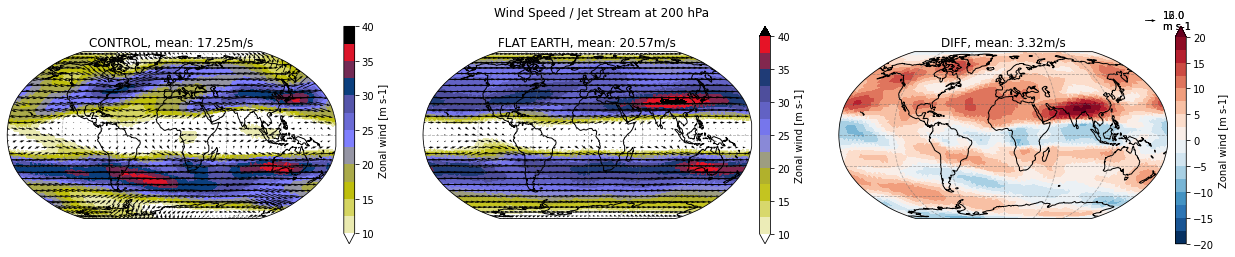

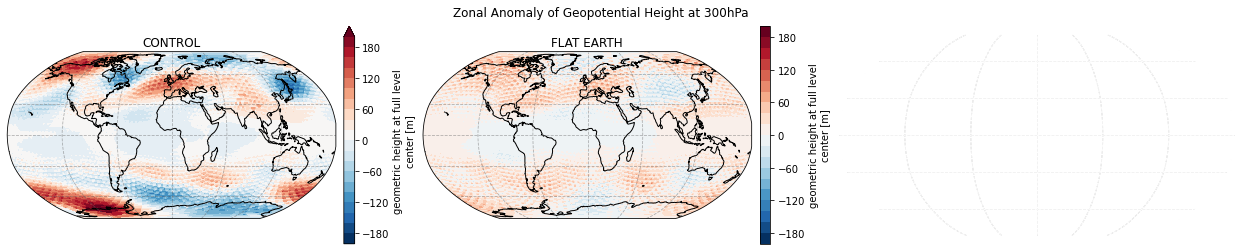

In [49]:
""" Plot Windspeed at 200 hPa to show Jetstream """

windspeed_ctrl=xr.ufuncs.sqrt((ds_atm_3d_ctrl_regrid_pressure.ua**2+ds_atm_3d_ctrl_regrid_pressure.va**2))
windspeed=xr.ufuncs.sqrt((ds_atm_3d_regrid_pressure.ua**2+ds_atm_3d_regrid_pressure.va**2))

var=windspeed.sel(plevc=200e2)
var_ctrl=windspeed_ctrl.sel(plevc=200e2)
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4],num=1)

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=10,vmax=40,vdel=2.5,var=var,cmap_in=plt.cm.gist_stern_r)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-20,vmax=20,vdel=2.5,var=var_diff,cmap_in=plt.cm.RdBu_r,center=0)

var_ctrl.plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict) 
var.plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict)
var_diff.plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels_d,cmap=cmap_d,cbar_kwargs=cbar_dict) 

ds_atm_3d_ctrl_regrid_pressure.isel(lon=slice(0,360,8),lat=slice(0,180,6)).sel(plevc=200e2).plot.quiver(x='lon',y='lat',u='ua',v='va',scale=5e2,ax=axs[0],transform=ccrs.PlateCarree())
ds_atm_3d_regrid_pressure.isel(lon=slice(0,360,8),lat=slice(0,180,6)).sel(plevc=200e2).plot.quiver(x='lon',y='lat',u='ua',v='va',scale=5e2,ax=axs[1],transform=ccrs.PlateCarree())

weights = np.cos(np.deg2rad(var.lat))
var_mean = float(var.weighted(weights).mean(("lon", "lat")).values)
var_ctrl_mean = float(var_ctrl.weighted(weights).mean(("lon", "lat")).values)
var_diff_mean=float(var_diff.weighted(weights).mean(("lon", "lat")).values)

plot_adjust(fig,axs,suptitle='Wind Speed / Jet Stream at 200 hPa',
            titles=['CONTROL, mean: {:.2f}m/s'.format(var_ctrl_mean),'FLAT EARTH, mean: {:.2f}m/s'.format(var_mean),
                    'DIFF, mean: {:.2f}m/s'.format(var_diff_mean)])


""" Plot geopotential height anomaly at 300 hPa to inspect stationary waves """
### Stationary Waves, e.g. https://link.springer.com/article/10.1007/s40641-019-00147-6
### google images "atmosphere stationary wave geopotential height"

var=zg_star_anom.sel(plevc=300e2)
var_ctrl=zg_star_anom_ctrl.sel(plevc=300e2)
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4],num=2)
axs[2].axis('off')

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=-200,vmax=200,vdel=20,var=var,cmap_in=plt.cm.RdBu_r,center=0)

var_ctrl.plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict) 
var.plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict)

plot_adjust(fig,axs,suptitle='Zonal Anomaly of Geopotential Height at 300hPa')
axs[2].clear(); axs[2].axis('off'); axs[2].gridlines(color='w',lw=10,linestyle='-');

The removal of orographic obstacles leads to a much more undisturbed zonal circulation in the atmosphere. Particularly in the norhern hemisphere, the jet stream becomes significantly stronger and less deflected by stationary waves.

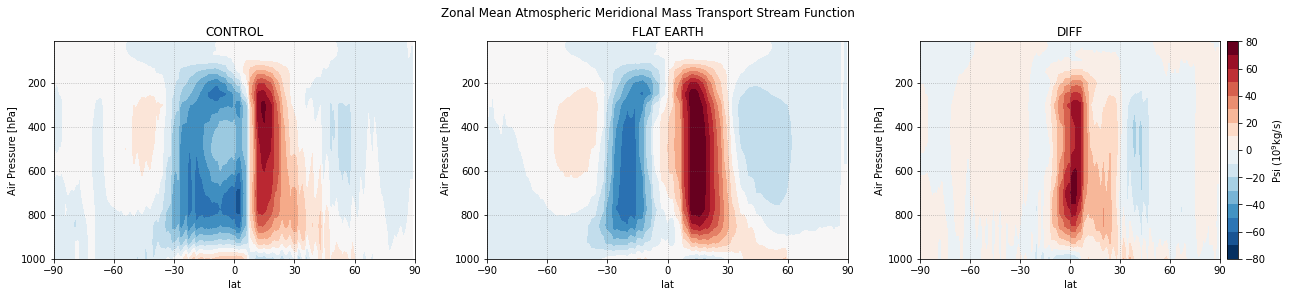

In [51]:
""" Plot the atmospheric meriodional stream function """

psi_ctrl=overturning_atm(ds_atm_3d_ctrl_regrid_pressure)
psi=overturning_atm(ds_atm_3d_regrid_pressure)

var=psi
var_ctrl=psi_ctrl
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,figsize=[22,4]) 

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=-80,vmax=80,vdel=10,var=var,cmap_in=plt.cm.RdBu_r)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-50,vmax=50,vN=10,var=var_diff,cmap_in=plt.cm.RdBu_r)

var_ctrl.plot.contourf(ax=axs[0],levels=levels,cmap=cmap,x='lat',y='plevc',add_colorbar=False) 
var.plot.contourf(ax=axs[1],levels=levels,cmap=cmap,x='lat',y='plevc',add_colorbar=False)
var_diff.plot.contourf(ax=axs[2],levels=levels,cmap=cmap_d,x='lat',y='plevc',cbar_kwargs={'pad':0.02,'label':'Psi (10$^9$kg/s)'}) 

for aa in axs:
    aa.invert_yaxis()
    aa.set_ylabel('Air Pressure [hPa]')
    aa.grid(c='dimgrey',ls=':', alpha=0.5)
    aa.set_yticks(np.arange(20e3,100e3+20e3,20e3))
    aa.set_yticklabels(np.arange(200,1000+200,200))
    aa.set_xlim([-90,90])
    aa.set_xticks(range(-90,90+30,30))

axs[0].set_title('CONTROL')
axs[1].set_title('FLAT EARTH')
axs[2].set_title('DIFF')
fig.suptitle('Zonal Mean Atmospheric Meridional Mass Transport Stream Function', y=1)

plt.subplots_adjust(wspace=0.2)

As the high latitudes of the northern hemisphere become cooler and Antarctica warm, the interhemispheric temperature contrast is reduced. The simulated changes in the annual mean meridional atmospheric stream function show that this results in a shift of the ITCZ from its north-displaced position towards the South Pole. The meridional circulation becomes more symmetric between the hemispheres with a stronger Hadley cell on the northern hemisphere. 

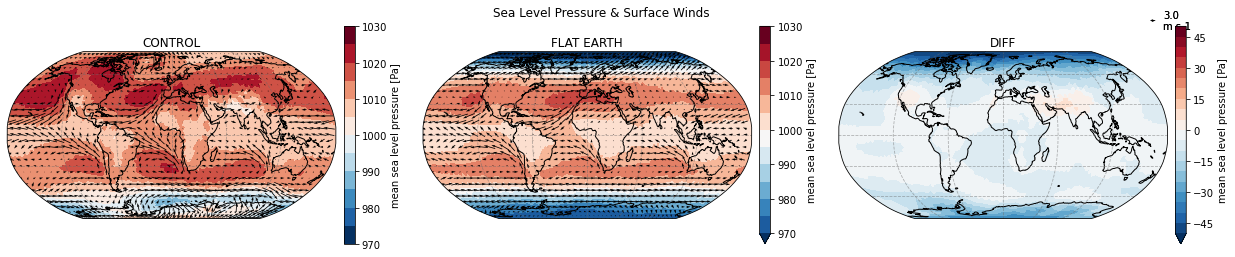

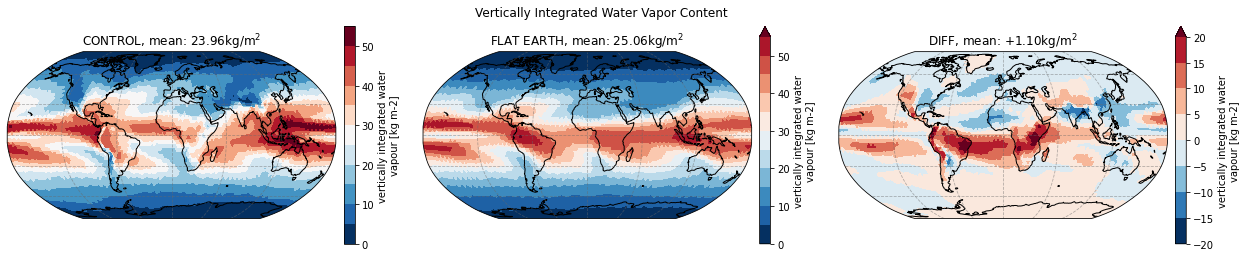

In [53]:
""" Plot Sea Level Pressure and Surface Wind Speeds """

varname='psl'
var=ds_atm_2d_regrid.data_vars[varname].mean('time')/100 # in hPa
var_ctrl=ds_atm_2d_ctrl_regrid.data_vars[varname].mean('time')/100
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4],num=1)

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=970,vmax=1030,vdel=5,var=var,cmap_in=plt.cm.RdBu_r)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-50,vmax=50,vdel=5,var=var_diff,cmap_in=plt.cm.RdBu_r,center=0)

var_ctrl.plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict) 
var.plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict)
var_diff.plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels_d,cmap=cmap_d,cbar_kwargs=cbar_dict) 

ds_atm_2d_ctrl_regrid.mean('time').isel(height=0,height_2=0,lon=slice(0,360,8),lat=slice(0,180,6)).plot.quiver(x='lon',y='lat',u='uas',v='vas',scale=2e2,ax=axs[0],transform=ccrs.PlateCarree())
ds_atm_2d_regrid.mean('time').isel(height=0,height_2=0,lon=slice(0,360,8),lat=slice(0,180,6)).plot.quiver(x='lon',y='lat',u='uas',v='vas',scale=2e2,ax=axs[1],transform=ccrs.PlateCarree())

plot_adjust(fig,axs,suptitle='Sea Level Pressure & Surface Winds') 


""" Plot Vertically Integrated Water Vapor Content of the Atmosphere """

varname='prw'
var=ds_atm_2d_regrid.data_vars[varname].mean('time')
var_ctrl=ds_atm_2d_ctrl_regrid.data_vars[varname].mean('time')
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4],num=2)

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=0,vmax=55,vdel=5,var=var,cmap_in=plt.cm.RdBu_r)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-20,vmax=20,vdel=5,var=var_diff,cmap_in=plt.cm.RdBu_r,center=0)

var_ctrl.plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict) 
var.plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict)
var_diff.plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels_d,cmap=cmap_d,cbar_kwargs=cbar_dict) 

weights = np.cos(np.deg2rad(var.lat))
var_mean = float(var.weighted(weights).mean(("lon", "lat")).values)
var_ctrl_mean = float(var_ctrl.weighted(weights).mean(("lon", "lat")).values)
var_diff_mean=float(var_diff.weighted(weights).mean(("lon", "lat")).values)

plot_adjust(fig,axs,suptitle='Vertically Integrated Water Vapor Content',
            titles=['CONTROL, mean: {:.2f}kg/m$^2$'.format(var_ctrl_mean),'FLAT EARTH, mean: {:.2f}kg/m$^2$'.format(var_mean),
                    'DIFF, mean: {:+.2f}kg/m$^2$'.format(var_diff_mean)])

## Ocean Salinity, Overturning

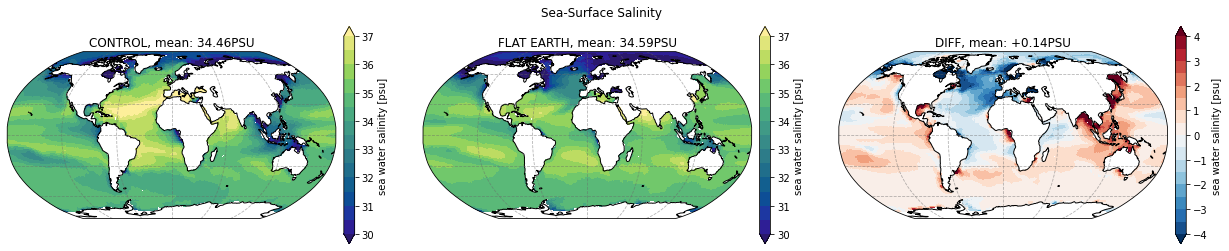

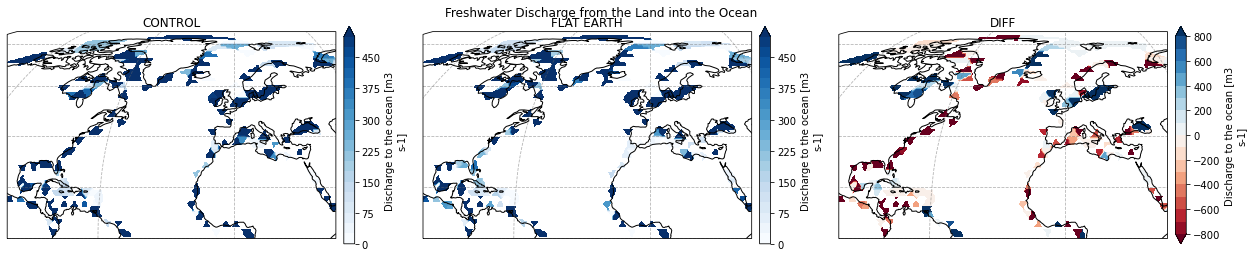

In [4]:
""" Plot Sea Surface Salinity """

varname='so'
var=ds_oce_regrid.data_vars[varname].isel(depth=0).mean('time')
var_ctrl=ds_oce_ctrl_regrid.data_vars[varname].isel(depth=0).mean('time')
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4],num=1)

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=30,vmax=37,vdel=0.5,var=var,cmap_in=cmocean.cm.haline)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-4,vmax=4,vdel=0.5,var=var_diff,cmap_in=plt.cm.RdBu_r,center=0)

var_ctrl.where(var_ctrl!=0).plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict) 
var.where(var!=0).plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict)
var_diff.where(var!=0).plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels_d,cmap=cmap_d,cbar_kwargs=cbar_dict)

weights = np.cos(np.deg2rad(var.lat))
var_mean = float(var.where(var!=0).weighted(weights).mean(("lon", "lat")).values)
var_ctrl_mean = float(var_ctrl.where(var_ctrl!=0).weighted(weights).mean(("lon", "lat")).values)
var_diff_mean=float(var_diff.where(var!=0).weighted(weights).mean(("lon", "lat")).values)

plot_adjust(fig,axs,suptitle='Sea-Surface Salinity',
            titles=['CONTROL, mean: {:.2f}PSU'.format(var_ctrl_mean),'FLAT EARTH, mean: {:.2f}PSU'.format(var_mean),
                    'DIFF, mean: {:+.2f}PSU'.format(var_diff_mean)])


""" Plot Freshwater Discharge from the Land into the Ocean """

varname='hydro_discharge_ocean_box'
var=ds_lnd_regrid.data_vars[varname].mean('time')
var_ctrl=ds_lnd_ctrl_regrid.data_vars[varname].mean('time')
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4],num=2)

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=0,vmax=500,vdel=25,var=var,cmap_in=plt.cm.Blues)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-800,vmax=800,vdel=100,var=var_diff,cmap_in=plt.cm.RdBu)

var_ctrl.where(var_ctrl>0).plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict) 
var.where(var>0).plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict)
var_diff.where(xr.ufuncs.fabs(var_diff)>0).plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels_d,cmap=cmap_d,cbar_kwargs=cbar_dict)

for aa in axs:
    aa.set_extent((-100.1,45.1,-0.1,90),crs=ccrs.PlateCarree())
plot_adjust(fig,axs,suptitle='Freshwater Discharge from the Land into the Ocean')   

In the Flat Earth experiment, sea surface salinities in the North Alantic and the Arctic sea are significantly increased. In contrast, most of the rest of the global surface ocean becomse more saline, with the strongest increases around the eastern and southern coasts of Asia.

Changes of freshwater from land surface runoff for the north Atlantic are both positive and negative. The strong increase in the Hundsonbai, whihc could result from more humid contitions in northern North America, seems to contribute to reduced salinity in the northwestern Atlantic. 
In the western North Atlantic, rather an increase in the precipitation-minus-evaporation balance appears responsible for the seawater freshening. (see [below](#sec:prec))


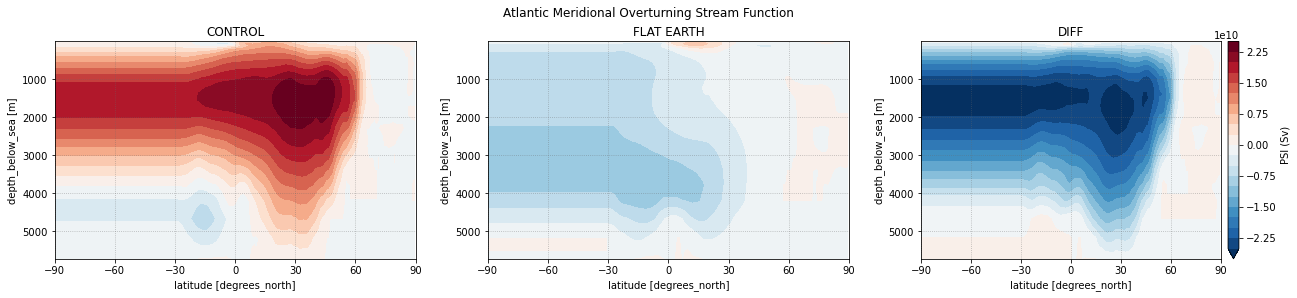

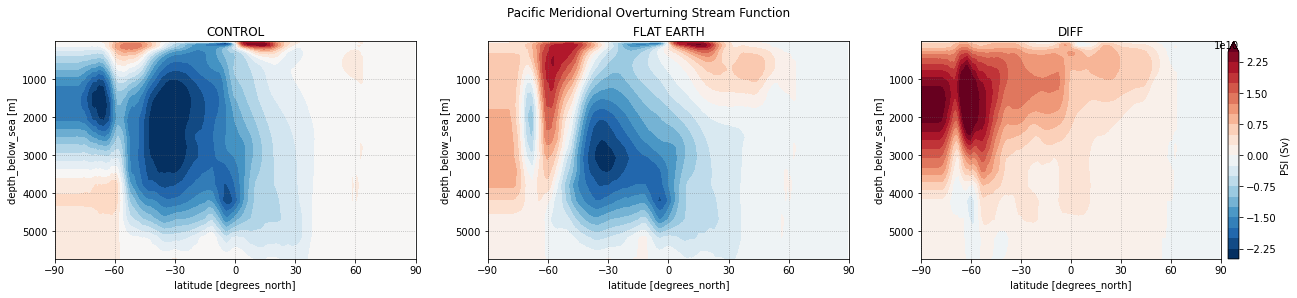

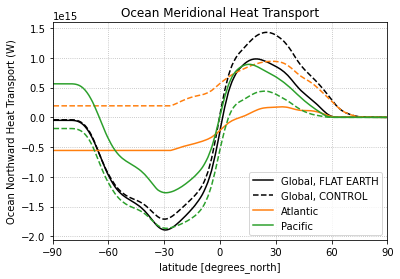

In [58]:
""" Plot Atlantic Ocean Meridional Overturning """

varname='atlantic_moc'
var=ds_oce_moc.data_vars[varname].isel(lon=0).mean('time')#*1e-6 # Sverdrup
var_ctrl=ds_oce_moc_ctrl.data_vars[varname].isel(lon=0).mean('time')#*1e-6
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,figsize=[22,4],num=1)

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=-25e9,vmax=25e9,vdel=2.5e9,var=var,cmap_in=plt.cm.RdBu_r,center=0)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-25e9,vmax=25e9,vdel=2.5e9,var=var_diff,cmap_in=plt.cm.RdBu_r,center=0)

var_ctrl.plot.contourf(ax=axs[0],levels=levels,cmap=cmap,add_colorbar=False) 
var.plot.contourf(ax=axs[1],levels=levels,cmap=cmap,add_colorbar=False)
var_diff.plot.contourf(ax=axs[2],levels=levels_d,cmap=cmap_d,cbar_kwargs={'pad':0.02,'label':'PSI (Sv)'}) 

for aa in axs:
    aa.invert_yaxis()
    aa.grid(c='dimgrey',ls=':', alpha=0.5)
    aa.set_xlim([-90,90])
    aa.set_xticks(range(-90,90+30,30))

axs[0].set_title('CONTROL')
axs[1].set_title('FLAT EARTH')
axs[2].set_title('DIFF')
fig.suptitle('Atlantic Meridional Overturning Stream Function', y=1)

plt.subplots_adjust(wspace=0.2)


""" Plot Pacific Ocean Meridional Overturning """

varname='pacific_moc'
var=ds_oce_moc.data_vars[varname].isel(lon=0).mean('time')#*1e-6 # Sverdrup
var_ctrl=ds_oce_moc_ctrl.data_vars[varname].isel(lon=0).mean('time')#*1e-6
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,figsize=[22,4],num=2)

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=-25e9,vmax=25e9,vdel=2.5e9,var=var,cmap_in=plt.cm.RdBu_r,center=0)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-25e9,vmax=25e9,vdel=2.5e9,var=var_diff,cmap_in=plt.cm.RdBu_r,center=0)

var_ctrl.plot.contourf(ax=axs[0],levels=levels,cmap=cmap,add_colorbar=False) 
var.plot.contourf(ax=axs[1],levels=levels,cmap=cmap,add_colorbar=False)
var_diff.plot.contourf(ax=axs[2],levels=levels_d,cmap=cmap_d,cbar_kwargs={'pad':0.02,'label':'PSI (Sv)'}) 

for aa in axs:
    aa.invert_yaxis()
    aa.grid(c='dimgrey',ls=':', alpha=0.5)
    aa.set_xlim([-90,90])
    aa.set_xticks(range(-90,90+30,30))

axs[0].set_title('CONTROL')
axs[1].set_title('FLAT EARTH')
axs[2].set_title('DIFF')
fig.suptitle('Pacific Meridional Overturning Stream Function', y=1)

plt.subplots_adjust(wspace=0.2)


""" Plot Global Overturning """

fig,ax=plt.subplots(1,1,num=3)

ds_oce_moc.global_hfbasin.mean(dim='time').plot(ax=ax,c='k',label='Global, FLAT EARTH')
ds_oce_moc_ctrl.global_hfbasin.mean(dim='time').plot(ax=ax,c='k',ls='--',label='Global, CONTROL')

ds_oce_moc_ctrl.atlantic_hfbasin.mean(dim='time').plot(ax=ax,c='tab:orange',ls='--')
ds_oce_moc.atlantic_hfbasin.mean(dim='time').plot(ax=ax,c='tab:orange',label='Atlantic')

ds_oce_moc_ctrl.pacific_hfbasin.mean(dim='time').plot(ax=ax,c='tab:green',ls='--')
ds_oce_moc.pacific_hfbasin.mean(dim='time').plot(ax=ax,c='tab:green',label='Pacific')

ax.set_title('Ocean Meridional Heat Transport')
ax.set_ylabel('Ocean Northward Heat Transport (W)')
ax.set_xlim([-90,90])
ax.set_xticks(range(-90,90+30,30))
ax.grid(c='dimgrey',ls=':', alpha=0.5)
ax.legend()

A complete shutdown of the AMOC is observed in the Flat Earth experiments. This could be related to the fresher and thus less dense surface waters and less deep water formation in the North Atlantic. Consequently, the Atlantic and global northwards heat transport by the ocean is reduced, contributing to the northern hemisphere cooling.

In contrast, overturning and northward heat transport in the North Pacific increases. In the southern hemisphere, Pacific overturning is reduced.

## Precipitation, Vegetation <a name="sec:prec"></a>

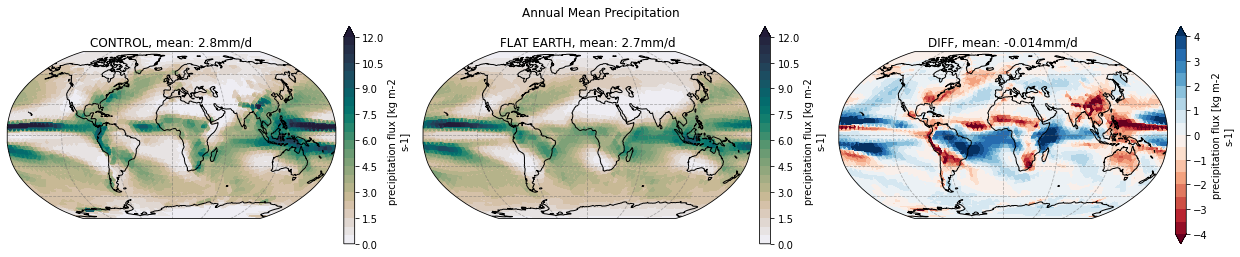

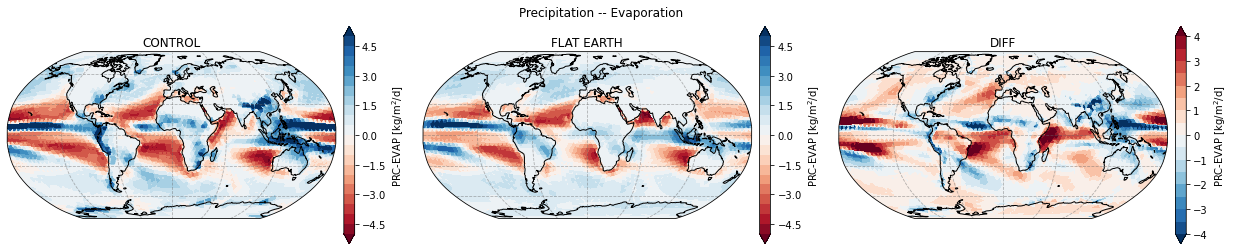

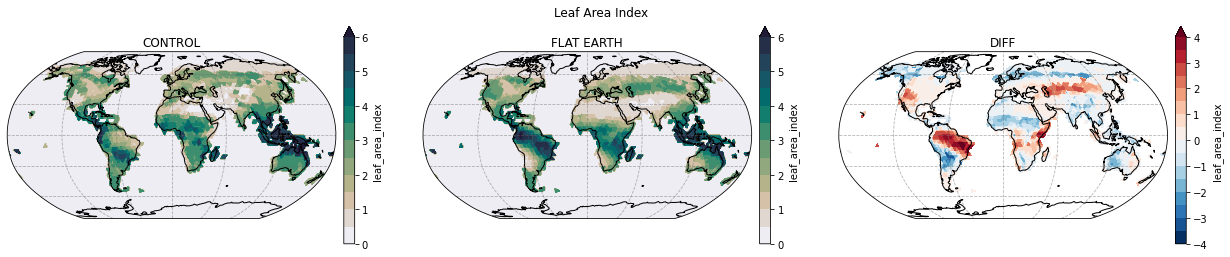

In [61]:
""" Plot Precipitation """

var=ds_atm_2d_regrid.pr.mean('time')*60*60*24
var_ctrl=ds_atm_2d_ctrl_regrid.pr.mean('time')*60*60*24
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4],num=1)

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=0,vmax=12,vdel=0.5,var=var,cmap_in=cmocean.cm.rain)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-4,vmax=4,vdel=0.5,var=var_diff,cmap_in=plt.cm.RdBu,center=0)

var_ctrl.plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict) 
var.plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict)
var_diff.plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels_d,cmap=cmap_d,cbar_kwargs=cbar_dict) 

weights = np.cos(np.deg2rad(var.lat))
var_mean = float(var.weighted(weights).mean(("lon", "lat")).values)
var_ctrl_mean = float(var_ctrl.weighted(weights).mean(("lon", "lat")).values)
var_diff_mean=float(var_diff.weighted(weights).mean(("lon", "lat")).values)

plot_adjust(fig,axs,suptitle='Annual Mean Precipitation',
            titles=['CONTROL, mean: {:.2}mm/d'.format(var_ctrl_mean),'FLAT EARTH, mean: {:.2}mm/d'.format(var_mean),
                    'DIFF, mean: {:+.2}mm/d'.format(var_diff_mean)])


""" Plot Precipitation-Evaporation Balance """

var=(ds_atm_2d_regrid.pr+ds_atm_2d_regrid.evspsbl).mean('time')*60*60*24
var_ctrl=(ds_atm_2d_ctrl_regrid.pr+ds_atm_2d_ctrl_regrid.evspsbl).mean('time')*60*60*24
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4],num=2)

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=-5,vmax=5,vdel=0.5,var=var,cmap_in=plt.cm.RdBu)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-4,vmax=4,vdel=0.5,var=var_diff,cmap_in=plt.cm.RdBu,center=0)

cbar_dict_tmp={'pad':0.02,'label':'PRC-EVAP [kg/m$^2$/d]'}
var_ctrl.plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict_tmp) 
var.plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict_tmp)
var_diff.where(var_diff!=0).plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels_d,cbar_kwargs=cbar_dict_tmp) 

plot_adjust(fig,axs,suptitle='Precipitation -- Evaporation')  


""" Plot Leaf Area Index """

varname='pheno_lai_box'
var=ds_lnd_regrid.data_vars[varname].mean('time')
var_ctrl=ds_lnd_ctrl_regrid.data_vars[varname].mean('time')
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4],num=3)

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=0,vmax=6,vdel=0.5,var=var,cmap_in=cmocean.cm.rain)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-4,vmax=4,vdel=0.5,var=var_diff,cmap_in=plt.cm.RdBu_r,center=0)

var_ctrl.plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict) 
var.plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict)
var_diff.where(var_diff!=0).plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels_d,cmap=cmap_d,cbar_kwargs=cbar_dict) 

for aa in axs:
    aa.set_extent((-180.1,180.1,-90.1,90),crs=ccrs.PlateCarree())
plot_adjust(fig,axs,suptitle='Leaf Area Index') 

Associated with the southward shift of the ITCZ, the northern tropics become overall less humid, while precipitation and precipitation-minus-evaporation increase in large parts of the southern tropics. As a consequence, more dense vegation is simulated in Brasil and equatorial Africa, whereas North Africa becomes drier and less vegetated. (However, the control run appears biased towards low vegetation cover for the Amazon rainforest.) 

Large parts of the northern mid-latitudes become more humid, as already discussed with respect to the reduced North Atlantic salinity. In central Asia this apparently fosters vegetation growth, while the latter is reduced at higher latitudes of, possibly due to the temperature decline. 

A strong reduction of rainfall appears to be associated with the removal of the Himalaya, which is discussed in the next section in terms of the Asian monsoon.

## Asian Monsoon

In [6]:
def monsoon_condi(ds_m):
    """ Determine monsoonal conditions from monthly precipitation rates, based on the criteria proposed by Wang et al. 2014 doi.org/10.5194/cp-10-2007-2014 """
    
    ### Calculate the seasonal mean precipitation, here for May-September (MJJAS) and November-March (NDJFM)
    prc_MJJAS=ds_m.pr.isel(time=np.arange(4,8+1,1)).mean(dim='time')*60*60*24
    prc_NDJFM=ds_m.pr.isel(time=[10,11,0,1,2]).mean(dim='time')*60*60*24

    ### Set the minimum seasonal precipitation difference for a monsoonal climate to 2.5 mm/day
    PRC_monsoon_crit=2.5

    ### Determine where the monsoon condition is fulfilled on the northern/southern hemisphere
    condi_monsoon_NH=((((prc_MJJAS-prc_NDJFM)>=PRC_monsoon_crit).where(ds_m.lat>=0))==1)
    condi_monsoon_SH=((((prc_MJJAS-prc_NDJFM)<=-PRC_monsoon_crit).where(ds_m.lat<=0))==1)
    
    return condi_monsoon_NH, condi_monsoon_SH

condi_monsoon_NH, condi_monsoon_SH=monsoon_condi(ds_atm_2d_regrid)
condi_monsoon_NH_ctrl, condi_monsoon_SH_ctrl=monsoon_condi(ds_atm_2d_ctrl_regrid)


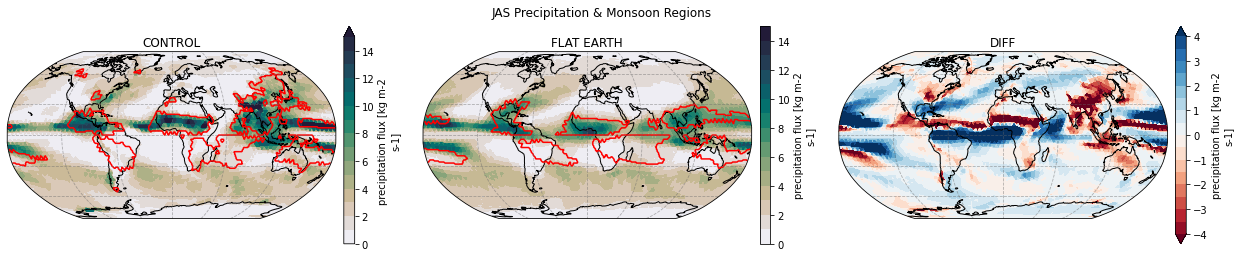

In [62]:
""" Plot July-August-September Precipitation and Monsoon Regions """

var=ds_atm_2d_regrid.pr.isel(time=[6,7,8]).mean('time')*60*60*24
var_ctrl=ds_atm_2d_ctrl_regrid.pr.isel(time=[6,7,8]).mean('time')*60*60*24
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4],num=1)

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=0,vmax=15,vdel=1,var=var,cmap_in=cmocean.cm.rain)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=-4,vmax=4,vdel=0.5,var=var_diff,cmap_in=plt.cm.RdBu)

var_ctrl.plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict) 
var.plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict)
var_diff.plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels_d,cmap=cmap_d,cbar_kwargs=cbar_dict) 
    
condi_monsoon_NH.plot.contour(ax=axs[1],transform=ccrs.PlateCarree(),colors='r',levels=[0.5])
condi_monsoon_SH.plot.contour(ax=axs[1],transform=ccrs.PlateCarree(),colors='r',levels=[0.5])
condi_monsoon_NH_ctrl.plot.contour(ax=axs[0],transform=ccrs.PlateCarree(),colors='r',levels=[0.5])
condi_monsoon_SH_ctrl.plot.contour(ax=axs[0],transform=ccrs.PlateCarree(),colors='r',levels=[0.5])

plot_adjust(fig,axs,suptitle='JAS Precipitation & Monsoon Regions');

The maps show that the Asian monsoon region shrinks strongly in the Flat Earth scenario and the Indian summer monsoon vanishes completely. This illustrates the importance of the topographic effect of the Himalaya and the Tibetan Plateau. Also the West African monsoon is significantly weakened and shifted southwards. The overall reduction of northern hemisphere tropical and subtropical summer rainfall also reflects the reduced northward displacement of tropical convergence, as the seasonal excursion of the ITCZ is a major factor for the global monsoon. 

## CO$_2$

Atmospheric CO2 concentration
   CONTROL: 269.75 ppm
   FLAT EARTH: 307.33 ppm
   DIFF: 37.58 ppm



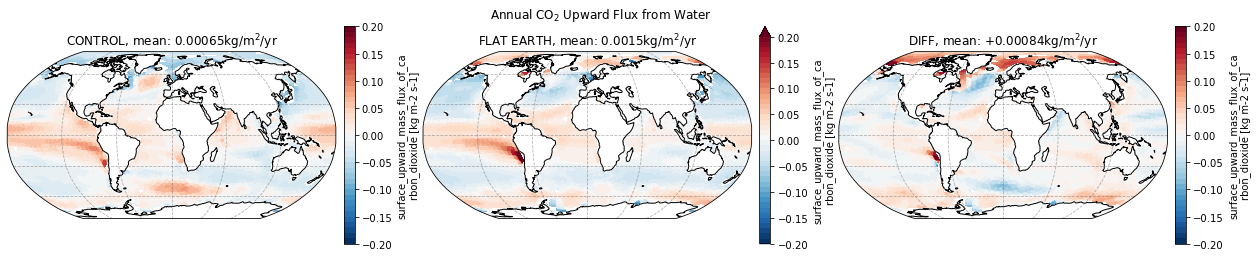

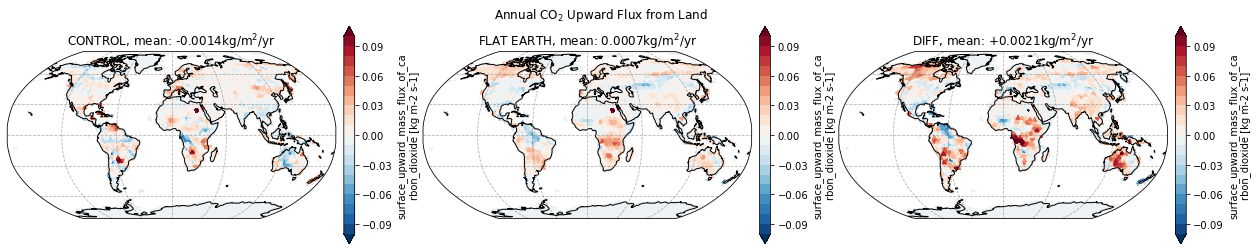

In [87]:
""" Plot CO_2 Flux from the Sea """

varname='co2_flux_wtr'
var=ds_atm_2d_regrid.data_vars[varname].mean('time')*60*60*24*365 # per year
var_ctrl=ds_atm_2d_ctrl_regrid.data_vars[varname].mean('time')*60*60*24*365
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4],num=1)

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=-0.2,vmax=0.2,vdel=0.01,var=var,cmap_in=plt.cm.RdBu_r)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=vmin,vmax=vmax,vdel=vdel,var=var_diff,cmap_in=plt.cm.RdBu_r)

var_ctrl.where(ds_atm_2d_ctrl_regrid.orog<5).plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict) 
var.where(ds_atm_2d_ctrl_regrid.orog<5).plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict)
var_diff.where(ds_atm_2d_ctrl_regrid.orog<5).plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels_d,cmap=cmap_d,cbar_kwargs=cbar_dict) 

weights = np.cos(np.deg2rad(var.lat))
var_mean = float(var.where(ds_atm_2d_ctrl_regrid.orog<5).weighted(weights).mean(("lon", "lat")).values)
var_ctrl_mean = float(var_ctrl.where(ds_atm_2d_ctrl_regrid.orog<5).weighted(weights).mean(("lon", "lat")).values)
var_diff_mean=float(var_diff.where(ds_atm_2d_ctrl_regrid.orog<5).weighted(weights).mean(("lon", "lat")).values)

plot_adjust(fig,axs,suptitle='Annual CO$_2$ Upward Flux from Water',
            titles=['CONTROL, mean: {:.2}kg/m$^2$/yr'.format(var_ctrl_mean),'FLAT EARTH, mean: {:.2}kg/m$^2$/yr'.format(var_mean),
                    'DIFF, mean: {:+.2}kg/m$^2$/yr'.format(var_diff_mean)])


""" Plot CO_2 Flux from Land """

varname='co2_flux_lnd'
var=ds_atm_2d_regrid.data_vars[varname].mean('time')*60*60*24*365 # per year
var_ctrl=ds_atm_2d_ctrl_regrid.data_vars[varname].mean('time')*60*60*24*365
var_diff=(var-var_ctrl)

fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.Robinson()},figsize=[22,4],num=2)

vmin,vmax,vdel,vN,levels,cmap=colormap_settings(vmin=-0.1,vmax=0.1,vdel=0.01,var=var,cmap_in=plt.cm.RdBu_r)
vmin_d,vmax_d,vdel_d,vN_d,levels_d,cmap_d=colormap_settings(vmin=vmin,vmax=vmax,vdel=vdel,var=var_diff,cmap_in=plt.cm.RdBu_r)

var_ctrl.where(ds_atm_2d_ctrl_regrid.orog>5).plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict) 
var.where(ds_atm_2d_ctrl_regrid.orog>5).plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=levels,cmap=cmap,cbar_kwargs=cbar_dict)
var_diff.where(ds_atm_2d_ctrl_regrid.orog>5).plot.contourf(ax=axs[2],transform=ccrs.PlateCarree(),levels=levels_d,cmap=cmap_d,cbar_kwargs=cbar_dict) 

weights = np.cos(np.deg2rad(var.lat))
var_mean = float(var.where(ds_atm_2d_ctrl_regrid.orog>5).weighted(weights).mean(("lon", "lat")).values)
var_ctrl_mean = float(var_ctrl.where(ds_atm_2d_ctrl_regrid.orog>5).weighted(weights).mean(("lon", "lat")).values)
var_diff_mean=float(var_diff.where(ds_atm_2d_ctrl_regrid.orog>5).weighted(weights).mean(("lon", "lat")).values)

plot_adjust(fig,axs,suptitle='Annual CO$_2$ Upward Flux from Land',
            titles=['CONTROL, mean: {:.2}kg/m$^2$/yr'.format(var_ctrl_mean),'FLAT EARTH, mean: {:.2}kg/m$^2$/yr'.format(var_mean),
                    'DIFF, mean: {:+.2}kg/m$^2$/yr'.format(var_diff_mean)])


""" Print global atmospheric CO_2 concentration """

var_ctrl=ds_atm_mon_ctrl.co2_gmean.data[0,0,0]
var=ds_atm_mon.co2_gmean.data[0,0,0]
var_diff=var-var_ctrl
print('Atmospheric CO2 concentration\n'+'   CONTROL: {:.2f} ppm\n'.format(var_ctrl)+
      '   FLAT EARTH: {:.2f} ppm\n'.format(var)+'   DIFF: {:.2f} ppm\n'.format(var_diff))

# var_ctrl=ds_hamocc_monitor_ctrl.global_net_co2_flux.mean('time').data[0,0]
# var=ds_hamocc_monitor.global_net_co2_flux.mean('time').data[0,0]
# var_diff=var-var_ctrl
# print('Global Net CO2 Flux into the Ocean\n'+'   CONTROL: {:.4f} GtC/yr\n'.format(var_ctrl)+
#       '   FLAT EARTH: {:.4f} GtC/yr\n'.format(var)+'   DIFF: {:.4f} GtC/yr\n'.format(var_diff))

As discussed above, removing the global orography alters ocean circulation and temperatures as well as the land surface characteristics, such as vegetation. These and other effects (soils, marine biogeochemistry) inevitably affect the cycling of carbon in the Earth system which then feeds back on the climatic changes.

An increase of the atmospheric CO$_2$ concentration by ~38 ppm is simulated for the Flat Earth scenario. The maps show, that there is an increased CO$_2$ flux from the ocean into the atmosphere in high and low latitudes, particularly in the Arctic. 